In [1]:
# cam visualization
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import soundfile as sf
import sys
from glob import glob
import pandas as pd
import torch
import matplotlib.pyplot as plt
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
sys.path.append('/root/projects/BirdClef2025/BirdCLEF2023-30th-place-solution-master/')
from model import BirdClefCNNFCModel,BirdClefSEDAttModel
from config import CFG

2025-04-21 08:11:34.681114: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:11:34.722001: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-21 08:11:34.722027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-21 08:11:34.723201: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-21 08:11:34.730314: I tensorflow/core/platform/cpu_feature_guar

In [2]:
class BirdClefSEDAttModelCAM(BirdClefSEDAttModel):
    def __init__(self, model_name=CFG.model, num_classes=CFG.num_classes, pretrained=CFG.pretrained, p=0.5):
        super().__init__(model_name, num_classes, pretrained, p)
    
    def forward(self, x, return_features=False):
        return super().forward(x, return_features)['clipwise_output']

In [ ]:
model = BirdClefCNNFCModel(model_name='tf_efficientnetv2_b3', num_classes = CFG.num_classes, pretrained = CFG.pretrained,p=0.5)
model.load_state_dict(torch.load('/root/projects/BirdClef2025/BirdCLEF2023-30th-place-solution-master/logs/2025-04-09T16:54-MLD-0.864/saved_model_lastepoch.pt',map_location='cpu'))

<All keys matched successfully>

In [4]:
def crop_or_pad(y, length, is_train=True, start=None):
    duration = 5
    sr = 32000
    len_y = len(y)
    effective_length = duration * sr
    if len_y < effective_length:
        new_y = np.ones(effective_length, dtype=y.dtype)*1e-9
        start = np.random.randint(effective_length - len_y)
        new_y[start:start + len_y] = y
        y = new_y.astype(np.float32)
    elif len_y > effective_length:
        start = np.random.randint(len_y - effective_length)
        y = y[start:start + effective_length].astype(np.float32)
    else:
        y = y.astype(np.float32)

    return y

In [5]:
classes_index = pd.read_csv('/root/projects/BirdClef2025/BirdCLEF2023-30th-place-solution-master/usefulFunc/train.csv')
classes_index = list(pd.get_dummies(classes_index['primary_label']).columns)

In [18]:
class_name = 'bugtan'
filename = f'/root/projects/BirdClef2025/data/train_audio/{class_name}/*'
filelist = glob(filename)
filelist.sort()
index = np.random.randint(0,len(filelist),1)[0]

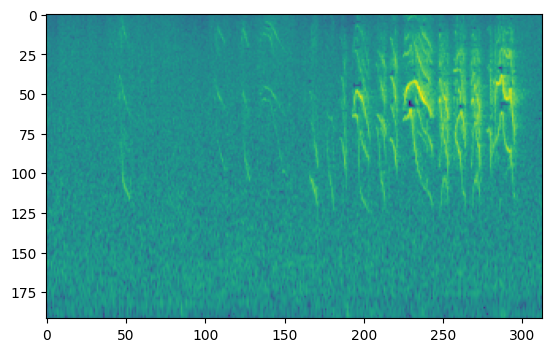

In [19]:
filename = filelist[index]
wave,_ = sf.read(filename)
crop_wave = crop_or_pad(wave,length=32000*5)
crop_wave = torch.from_numpy(crop_wave).to(torch.float32).unsqueeze(0)
data_mel = model.get_mel_gram(crop_wave)
gray_image = np.rot90(data_mel.detach().cpu().numpy()[0],k=1)
rgb_image = np.repeat(gray_image[...,None],repeats=3,axis=-1)
input_tensor = torch.repeat_interleave(data_mel,repeats=3,dim=0).unsqueeze(0)
plt.imshow(gray_image)

In [20]:
target_layer = model.backbone.conv_head
cls_index = classes_index.index(class_name)
# cls_index = 7

In [21]:
cam = GradCAM(model=model, target_layers=[target_layer])
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(cls_index)])
pred = model(input_tensor)

In [22]:
torch.sigmoid(pred)[0,cls_index]

tensor(0.5973, grad_fn=<SelectBackward0>)

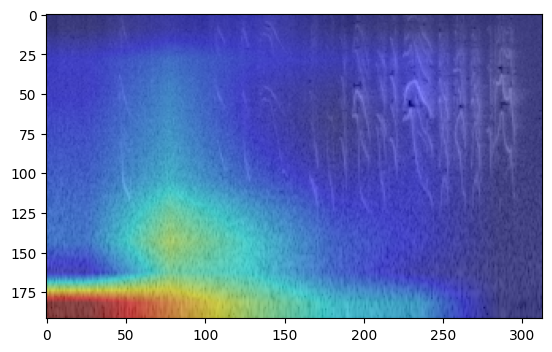

In [23]:
vis_image = show_cam_on_image(rgb_image, np.rot90(grayscale_cam[0],k=3), use_rgb=True)
plt.imshow(vis_image)